In [10]:
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sympy
import datetime

# для расчетов над tdb
# from pycalphad import Database, equilibrium, variables as v, binplot

# для MCMC расчетов
import pymc as pm  # пакет для MCMC расчетов 
import arviz as az # пакет для работы с типом данных arviz
import pytensor
import pytensor.tensor as pt
# import theano
# theano.config.exception_verbosity = 'high' # должно выдавать подробное описание ошибки, но не помогает

import aesara

import seaborn as sns

# пути к tdb
db_path = 'tdbs/CoCr-18Cac_with_new_functions.tdb'

print(f"Running on PyMC v{pm.__version__}") # 5.3.1 or 5.1.2
print(f"Running on NumPy v{np.__version__}") # 1.22.1
print(f"Running on ArviZ v{az.__version__}") # 0.12.1

Running on PyMC v5.3.1
Running on NumPy v1.22.1
Running on ArviZ v0.15.1


In [11]:
from pycalphad import Database
db = Database(db_path)

In [48]:
# для 0.5
df_sigma_fcc = pd.read_excel('emp_data/sigma_fcc_allibert.xls')
df_sigma_hcp = pd.read_excel('emp_data/sigma_hcp_allibert.xls')

df_hcp_fcc = pd.concat([df_sigma_fcc, df_sigma_hcp])

df_hcp_fcc['T'] = df_hcp_fcc['T'].round(2)
df_hcp_fcc['cr_conc'] = df_hcp_fcc['cr_conc'].round(6)
df_hcp_fcc = df_hcp_fcc[(df_hcp_fcc['phase'] == 'sigma_old')].reset_index()
df_hcp_fcc.sort_values('T', inplace=True)
df_hcp_fcc

,index,cr_conc,T,phase
6,7,0.541762,928.09,sigma_old
9,10,0.558231,973.03,sigma_old
7,8,0.545313,1020.22,sigma_old
8,9,0.551960,1069.66,sigma_old
10,11,0.559991,1121.35,sigma_old
12,13,0.565255,1168.54,sigma_old
11,12,0.560713,1217.98,sigma_old
1,7,0.542469,1226.97,sigma_old
4,10,0.556156,1269.66,sigma_old
0,6,0.532019,1321.35,sigma_old


In [69]:
# для 0.75
df_bcc = pd.read_excel('emp_data/sigma_bcc_allibert.xls')

df_bcc['T'] = df_bcc['T'].round(2)
df_bcc['cr_conc'] = df_bcc['cr_conc'].round(6)
df_bcc = df_bcc[(df_bcc['phase'] == 'sigma_old')].reset_index()
df_bcc.sort_values('T', inplace=True)
# df_bcc

Данные

In [2]:
trace = az.from_json('calc_res/trace_cocr18_2Sx700x1000x2_20230509.json')
ppc = az.from_json('calc_res/ppc_cocr18_2Sx700x1000x2_20230509.json')
pp = az.from_json('calc_res/pp_cocr18_2Sx2000_20230509.json')
main = trace.extend(ppc)
par_list = ['GSCRCO1', 'GSCOCRCO1', 'GSCOCRCO2', 'GSCRCO2', 'GSCOCR1',  'GSCOCR2', 'GSCOCR3']

In [9]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

График с цепями

array([[<Axes: title={'center': 'GSCRCO1'}>,
        <Axes: title={'center': 'GSCRCO1'}>],
       [<Axes: title={'center': 'GSCOCRCO1'}>,
        <Axes: title={'center': 'GSCOCRCO1'}>],
       [<Axes: title={'center': 'GSCOCRCO2'}>,
        <Axes: title={'center': 'GSCOCRCO2'}>],
       [<Axes: title={'center': 'GSCRCO2'}>,
        <Axes: title={'center': 'GSCRCO2'}>],
       [<Axes: title={'center': 'GSCOCR1'}>,
        <Axes: title={'center': 'GSCOCR1'}>],
       [<Axes: title={'center': 'GSCOCR2'}>,
        <Axes: title={'center': 'GSCOCR2'}>],
       [<Axes: title={'center': 'GSCOCR3'}>,
        <Axes: title={'center': 'GSCOCR3'}>]], dtype=object)

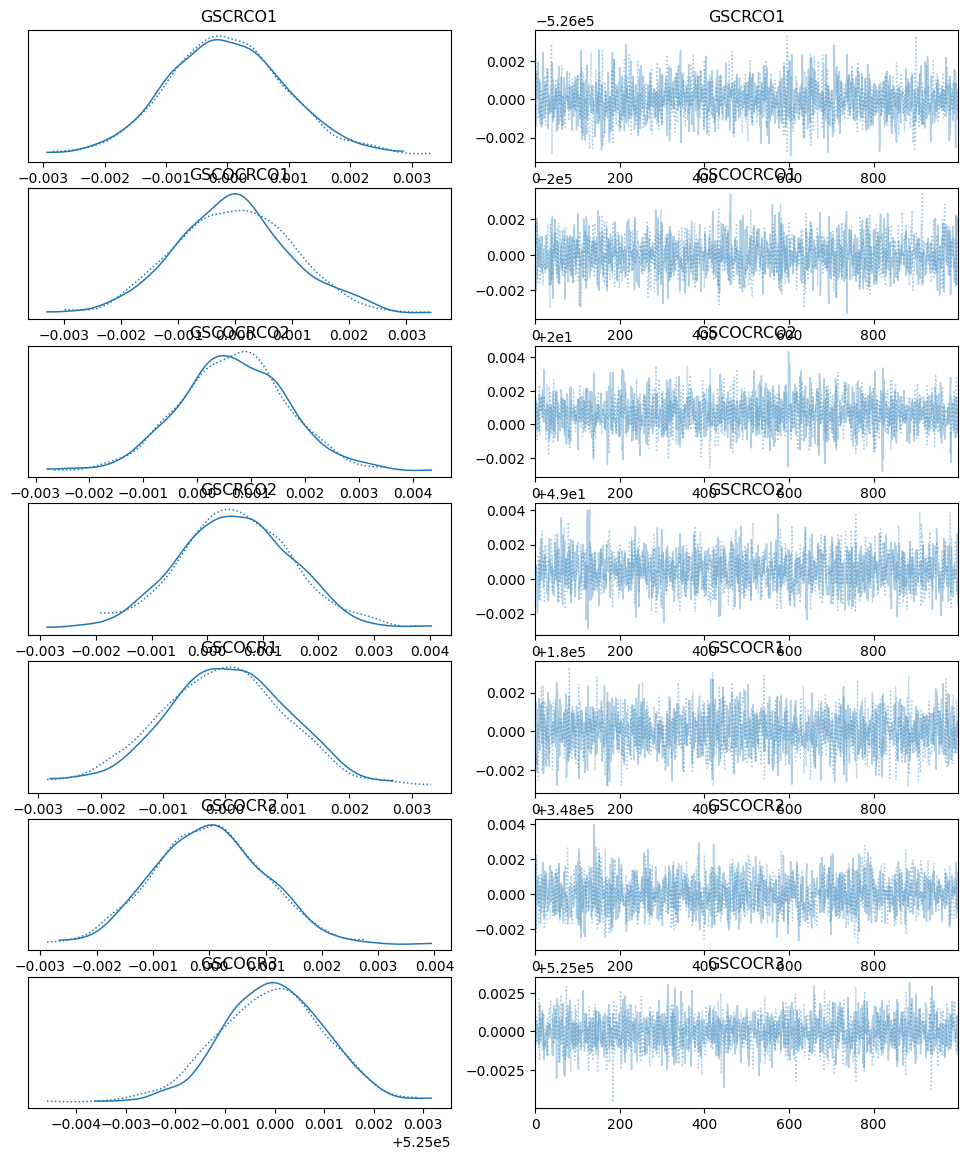

In [3]:
az.plot_trace(trace)

Саммери

In [4]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
GSCRCO1,-526000.000,0.001,-526000.002,-525999.998,0.0,0.0,1868.0,1354.0,1.0
GSCOCRCO1,-200000.000,0.001,-200000.002,-199999.998,0.0,0.0,1844.0,1345.0,1.0
GSCOCRCO2,20.001,0.001,19.999,20.003,0.0,0.0,2194.0,1495.0,1.0
GSCRCO2,49.001,0.001,48.999,49.002,0.0,0.0,1812.0,1184.0,1.0
GSCOCR1,180000.000,0.001,179999.998,180000.002,0.0,0.0,2143.0,1590.0,1.0
GSCOCR2,348000.000,0.001,347999.998,348000.002,0.0,0.0,1962.0,1605.0,1.0
GSCOCR3,525000.000,0.001,524999.998,525000.002,0.0,0.0,2133.0,1531.0,1.0


График автокорреляции

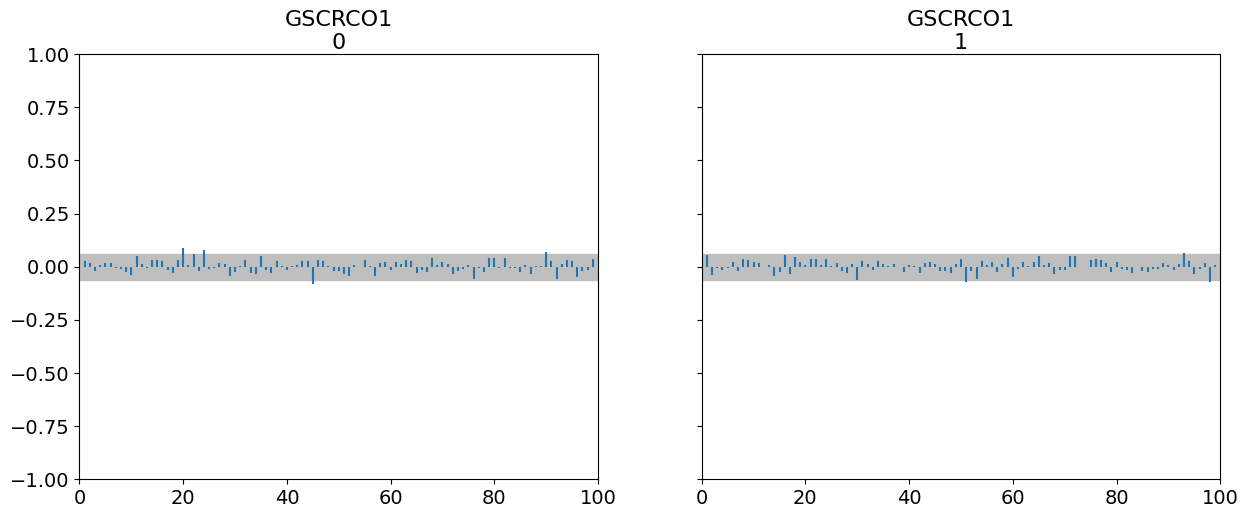

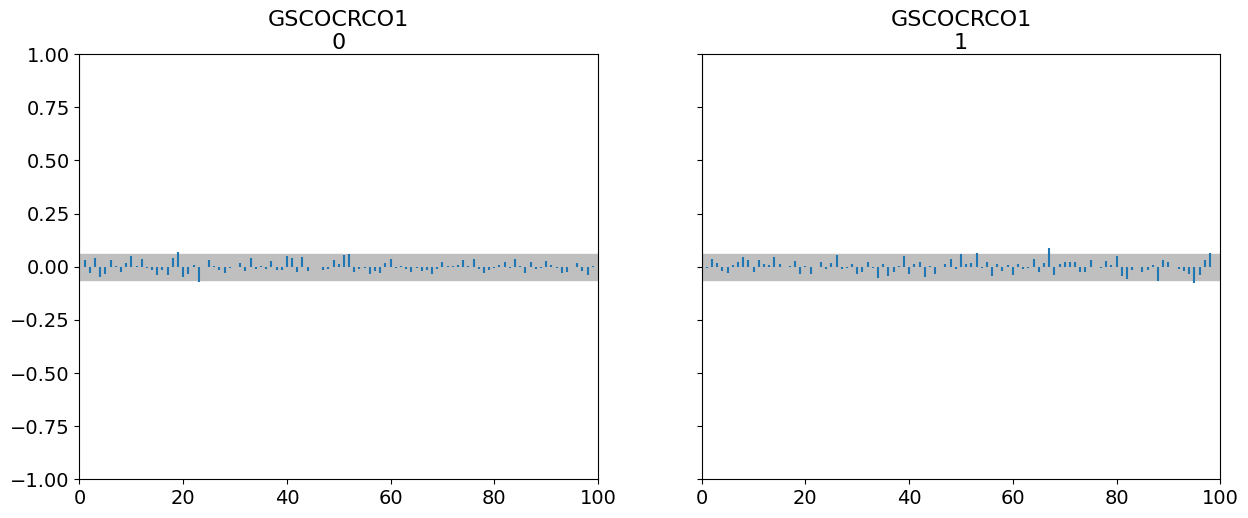

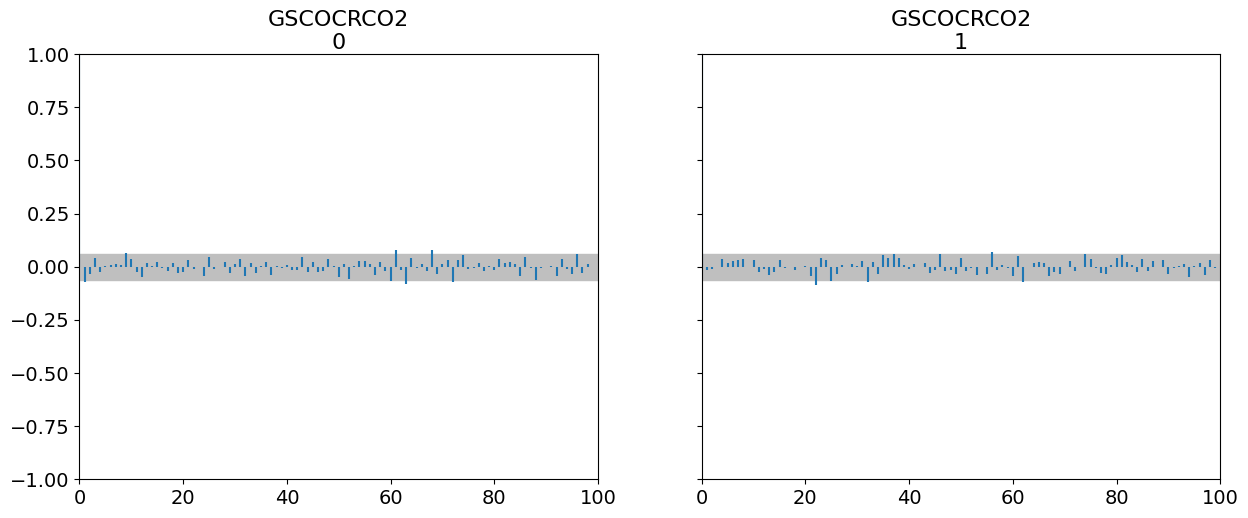

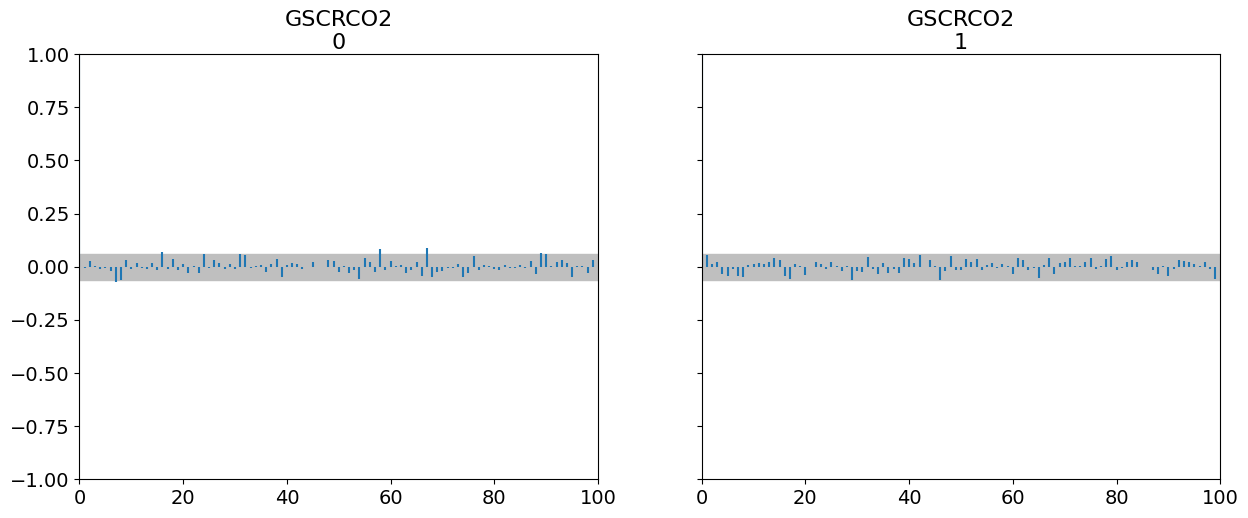

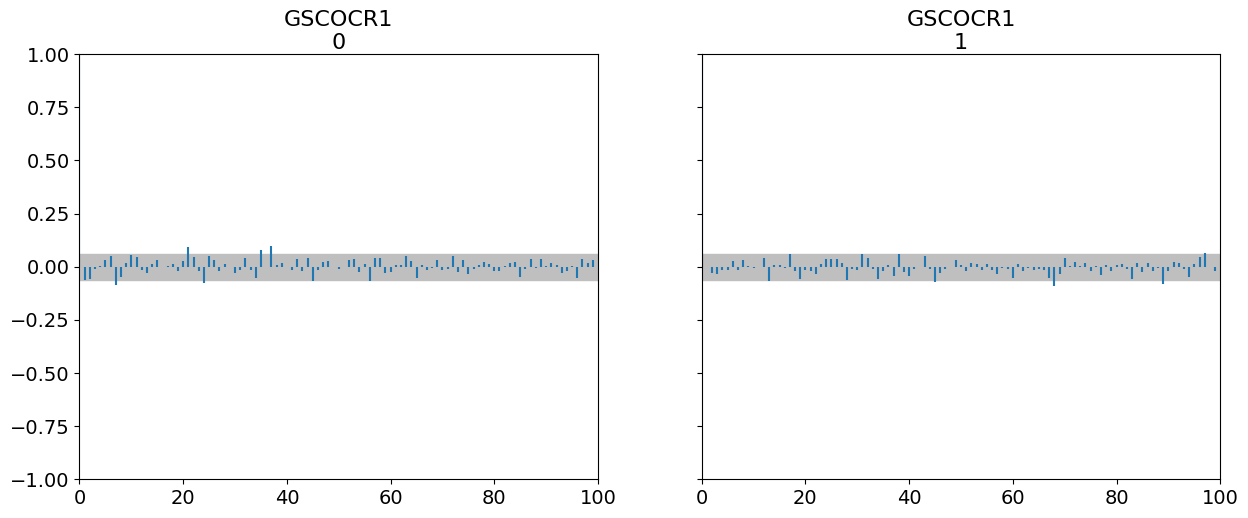

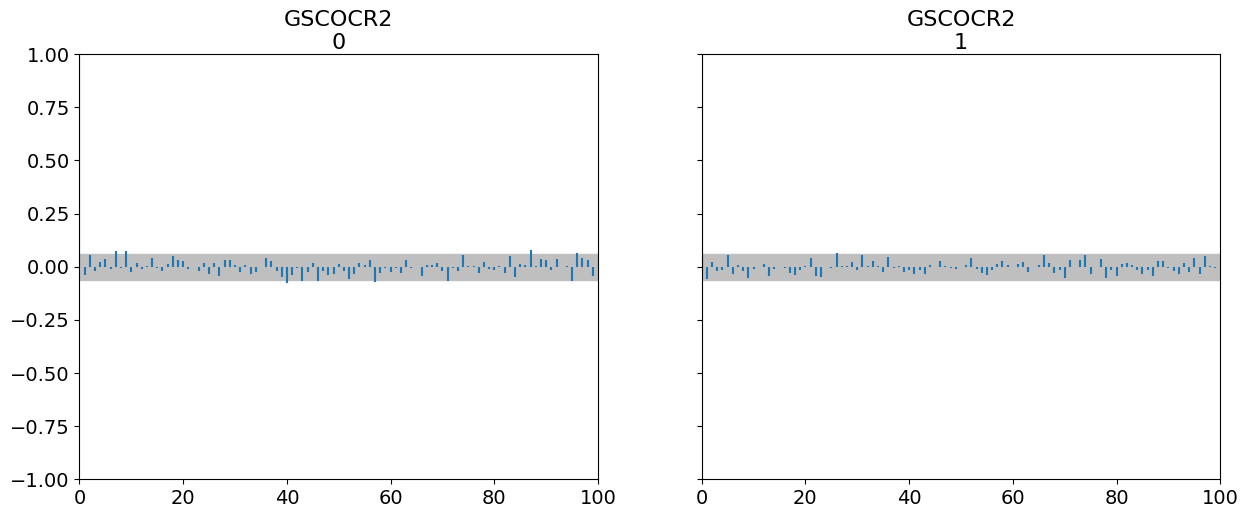

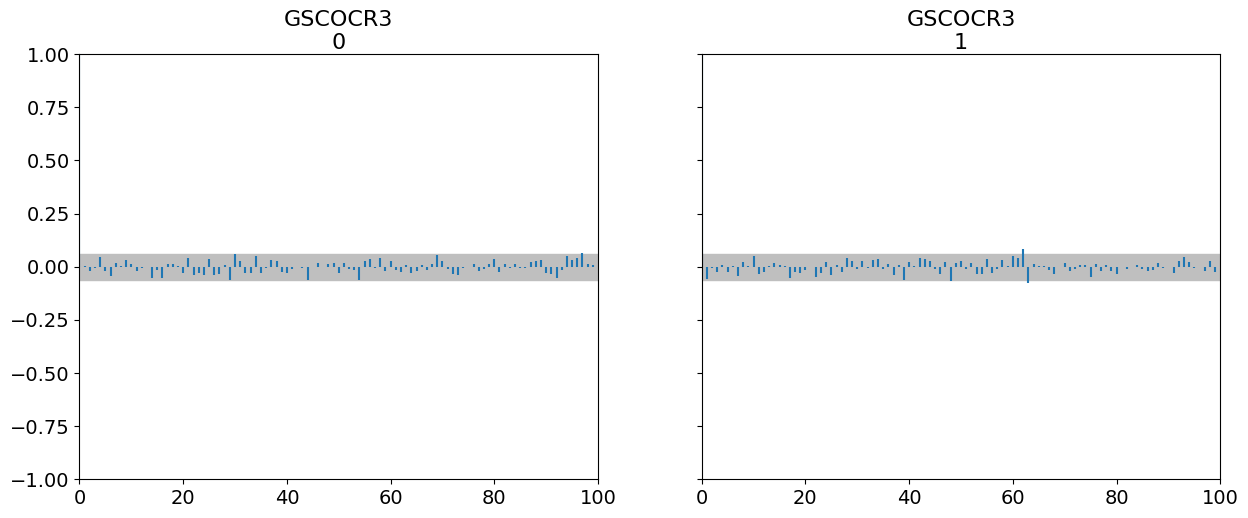

In [5]:
for par in par_list:
    az.plot_autocorr(trace, var_names = par)

Функции

In [42]:
# запись словаря со значениями параметров по tdb
def from_piecewise_to_dict(db, parameters_list):
    import sympy
    full_par_dict = db.symbols
    tdb_par_dict = dict()

    for par in parameters_list:
        tdb_par_dict[par] = np.float32(full_par_dict[par].args_as_sympy()[0])
    return tdb_par_dict

# собираем цепи в одну для каждого параметра, словарь
def chains_concatenate(traces, parameters_list):
    # создаем словарь с распределениями параметров
    par_chains_dict = dict()
    for par in parameters_list:
        par_chains_dict[par] = np.float32(np.concatenate(traces.posterior.variables[par]))
    
    # вычисляем объем каждого сэмпла
    chains_num = traces.sample_stats.chain.data.shape
    draws_num = traces.sample_stats.draw.data.shape
    num_points = chains_num[0]*draws_num[0]
    
    return num_points, par_chains_dict

# для каждого распределения параметра считаем распределение квадратов отклонений от значения в tdb
def mse_dictribution_dict(par_chains_dict, tdb_par_dict, par_list):
    mse_par_dict = dict()

    for par in par_list:
        mse_par_dict[par] = np.float_power(np.subtract(par_chains_dict[par], tdb_par_dict[par]), 2)

    return mse_par_dict

def from_ppc_to_temp_dict(ppc, var_name_str):
    yt_dict = dict()
    ppc_conc = np.concatenate(ppc.posterior_predictive.data_vars[var_name_str].data)
    t_num = ppc_conc.shape[1]
    p_num = ppc_conc.shape[0]
    
    for i in range(t_num):
        i_list = []
        
        for j in range(p_num):
            i_list.append(ppc_conc[j][i])

        yt_dict[i] = i_list # key = индекс температуры в T
    return yt_dict


Апостериорные вычисления

In [21]:
tdb_par_dict = from_piecewise_to_dict(db, par_list)
num, par_dict = chains_concatenate(trace, par_list)
mse_par_dict = mse_dictribution_dict(par_dict, tdb_par_dict, par_list)

Графики распределения квадратов отклонений

<Axes: ylabel='Count'>

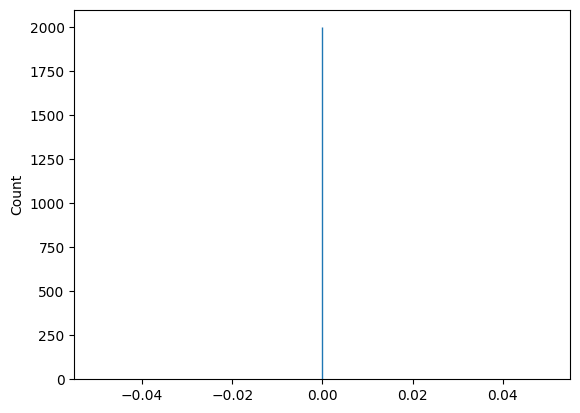

In [35]:
sns.histplot(mse_par_dict['GSCRCO1'], element="poly") #, kde=True element="poly"

<Axes: ylabel='Count'>

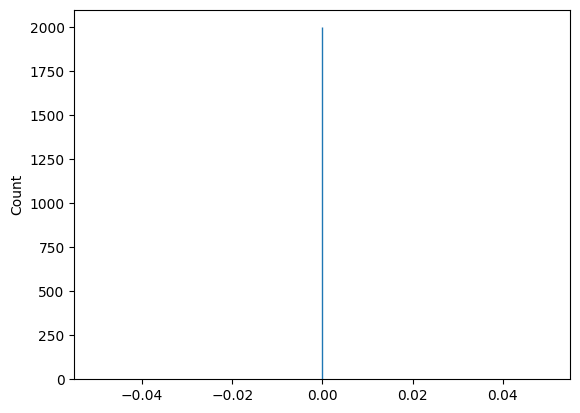

In [36]:
sns.histplot(mse_par_dict['GSCOCRCO1'], element="poly") #, kde=True element="poly"


<Axes: ylabel='Count'>

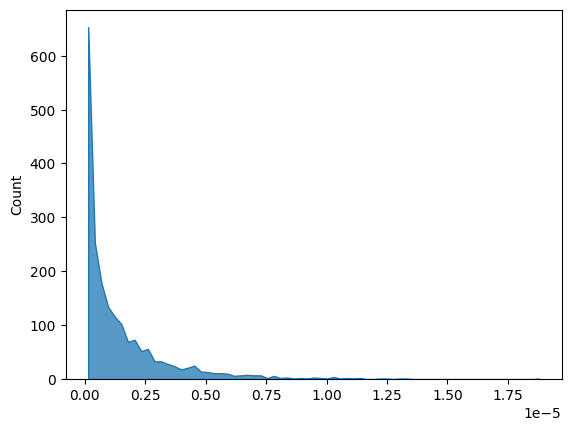

In [37]:
sns.histplot(mse_par_dict['GSCOCRCO2'], element="poly") #, kde=True element="poly"


<Axes: ylabel='Count'>

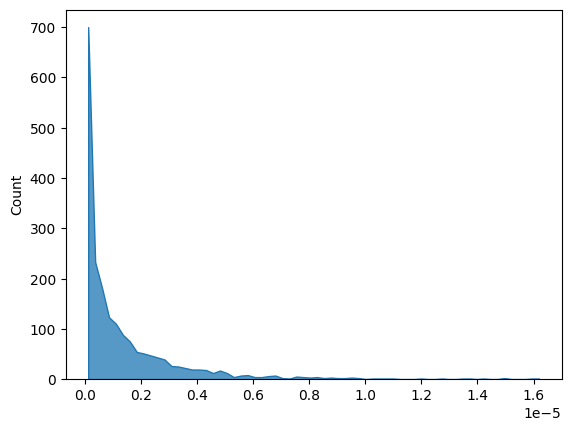

In [38]:
sns.histplot(mse_par_dict['GSCRCO2'], element="poly") #, kde=True element="poly"


<Axes: ylabel='Count'>

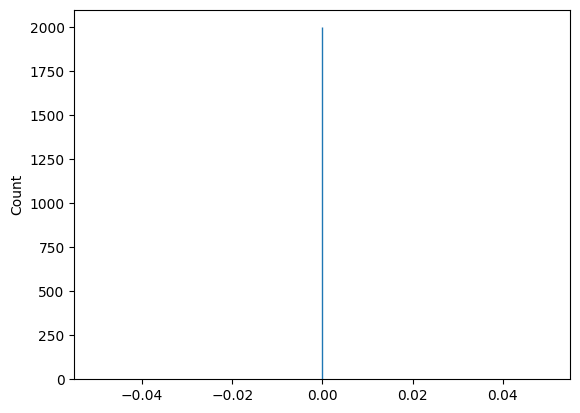

In [39]:
sns.histplot(mse_par_dict['GSCOCR1'], element="poly") #, kde=True element="poly"


<Axes: ylabel='Count'>

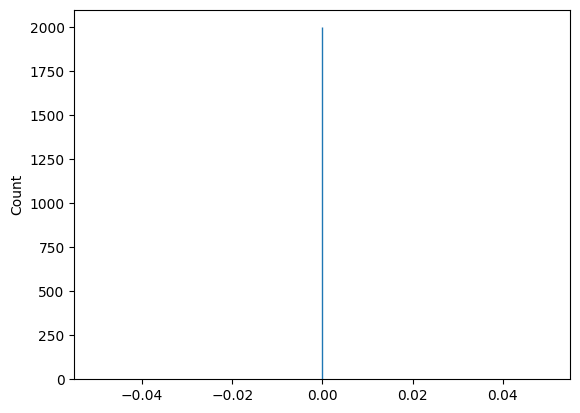

In [40]:
sns.histplot(mse_par_dict['GSCOCR2'], element="poly") #, kde=True element="poly"


<Axes: ylabel='Count'>

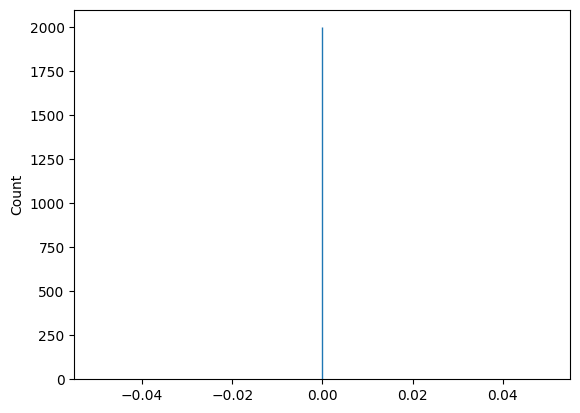

In [41]:
sns.histplot(mse_par_dict['GSCOCR3'], element="poly") #, kde=True element="poly"


График предсказаний

In [47]:
y_norm_05_temp_dict = from_ppc_to_temp_dict(ppc, 'y_norm_05')
y_norm_75_temp_dict = from_ppc_to_temp_dict(ppc, 'y_norm_75')

In [71]:
t_05 = df_hcp_fcc['T']
t_75 = df_bcc['T']

y_obs_05 = df_hcp_fcc['cr_conc']
y_obs_75 = df_bcc['cr_conc']

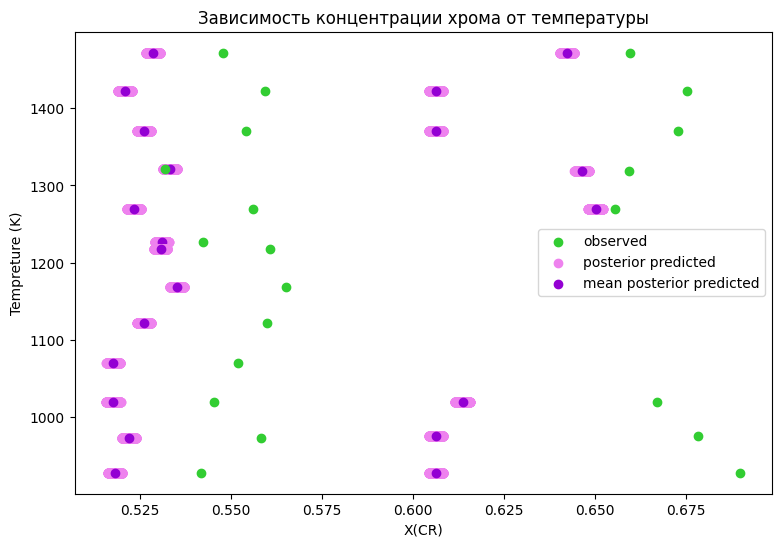

In [80]:
# Создаем фигуру и оси
fig = plt.figure(figsize=(9,6))
axes = fig.gca()

axes.set_title('Зависимость концентрации хрома от температуры')


# Добавляем точки на график и задаем метки для легенды

for i in range(len(t_05)):
    min_05 = np.percentile(y_norm_05_temp_dict[i], 2.5)
    max_05 = np.percentile(y_norm_05_temp_dict[i], 100-2.5)
    mean_05 = sum(y_norm_05_temp_dict[i])/len(y_norm_05_temp_dict[i])
    yt_05 = [x for x in y_norm_05_temp_dict[i] if x > min_05 and x < max_05]
    
    scatter2 = axes.scatter(yt_05, np.repeat(t_05[i], len(yt_05)), label='posterior predicted', color = 'violet')
    scatter3 = axes.scatter(mean_05, t_05[i], label='mean posterior predicted', color = 'darkviolet')


for i in range(len(t_75)):    
    min_75 = np.percentile(y_norm_75_temp_dict[i], 2.5)
    max_75 = np.percentile(y_norm_75_temp_dict[i], 100-2.5)
    y_75_10 = [x for x in y_norm_75_temp_dict[i] if x < 1]
    if len(y_75_10) > 0:
        yt_75 = [x for x in y_norm_75_temp_dict[i] if x > min_75 and x < max_75 and x < 1]
        mean_75 = sum(y_norm_75_temp_dict[i])/len(y_norm_75_temp_dict[i])

    
    scatter2 = axes.scatter(yt_75, np.repeat(t_75[i], len(yt_75)), label='posterior predicted', color = 'violet')    
    scatter3 = axes.scatter(mean_75, t_75[i], label='mean posterior predicted', color = 'darkviolet')


scatter1 = axes.scatter(y_obs_05, t_05, label='observed', color = 'limegreen')
scatter1 = axes.scatter(y_obs_75, t_75, label='observed', color = 'limegreen')

# Добавляем легенду на график
axes.legend(handles=[scatter1, scatter2, scatter3])

# Задаем название осей
axes.set_xlabel('X(CR)')
axes.set_ylabel('Tempreture (K)')

# Отображаем график
plt.show()